In [ ]:
# Summary

# Question 1: I took the business data set and split out the column fields into their own columns. This was basically given to us. From here I created two data frames to see how we would describe Vegas. 
# The first set split out the 'attribute' columns to see its effect on classification. Creating a tree classifier we see that the most influential data focused on smoking. This included the ability to smoke at all (I'm guessing a casino), smoke out doors (bar/restaurant), and where vape shops were. 
# These were all store level attributes and dont reflect user opinion as much as the next data set, which merged user reviews with businesses to get location data. These reviews were more typical Vegas, with the top node of bottle service, and the levels beneath it focused on drinking / partying. 

# Question 2: This one didn't work out so well. I tried to split the business into two groups based on the category filters provided and then merge these groups with user reviews. I chose targets of 'votes cool' and 'votes helpful' thinking food/bar based businesses would be more trendy while  
# services would be utilitarian. I didn't setup the tests correctly and would get the same data for each group. I would need to go back to the drawing board on this one. 

# Question 3: I seperated the year elite variable from the users table to see if year level activity explained elite status. It looks like it does as my models were between 77 and 89 percent in their classifications. 

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale, MinMaxScaler, normalize

from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier



plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
business = pd.read_csv('C:/Users/Brian/Desktop/Netflix/yelp_arizona_data/businesses_small_parsed.csv')
checkins = pd.read_csv('C:/Users/Brian/Desktop/Netflix/yelp_arizona_data/checkins_small_parsed.csv')
reviews = pd.read_csv('C:/Users/Brian/Desktop/Netflix/yelp_arizona_data/reviews_small_nlp_parsed.csv')
tips = pd.read_csv('C:/Users/Brian/Desktop/Netflix/yelp_arizona_data/tips_small_nlp_parsed.csv')
users = pd.read_csv('C:/Users/Brian/Desktop/Netflix/yelp_arizona_data/users_small_parsed.csv')

In [3]:
# Setup for adding 'category' columns:
categories = business.categories.apply(eval)
business_copy = business.copy()
business_copy['categories'] = categories

#simplified list of categories
given_cats = ['Airports', 'Breakfast & Brunch', 'Bubble Tea', 'Burgers', 'Bars', 'Bakeries', 'Breweries',
             'Cafes', 'Candy Stores', 'Comedy Clubs', 'Courthouses', 'Dance Clubs', 'Fast Food', 
             'Museums', 'Tattoo', 'Vape Shops', 'Yoga']

# Add 'category' columns:    
for cat in given_cats:
    business_copy[cat] = business_copy['categories'].apply(lambda x: cat in x)

In [4]:
# Isolate Variable Columns of Business df:
variables = business_copy[['business_id', 'variable','value']]

In [6]:
dfv = variables.pivot(index = 'business_id', columns='variable', values = 'value')

In [8]:
# Take Out 'Hours' Columns
dfv = dfv.iloc[:, 0:-19]

In [52]:
# Replace 'None' values; might still have actual 'none' strings in alcohol column

cols = dfv.columns

for column in cols:
    dfv[column] = dfv[column].map(lambda x: '0'if x is None else x)

In [9]:
# Add index for join
dfv['business_id'] = dfv.index

In [66]:
#dfv_merge = dfv.copy()

In [10]:
# For flat business matrix:
business_cols = ['business_id', 'city', 'review_count',  'stars',
       'Airports', 'Breakfast & Brunch', 'Bubble Tea', 'Burgers',
       'Bars', 'Bakeries', 'Breweries', 'Cafes', 'Candy Stores',
       'Comedy Clubs', 'Courthouses', 'Dance Clubs', 'Fast Food',
       'Museums', 'Tattoo', 'Vape Shops', 'Yoga']

# Create flat df:
business_flat = business_copy[business_cols]

# Drop any duplicates:
business_flat = business_flat.drop_duplicates()

In [ ]:
###################################################################################################

In [ ]:
## Summary:
    # business_flat: holds business_id and all the category data
    # dfv: holds business_id and all the attribute data
    # business_category_attribute = merged table

In [11]:
business_flat.head()

,business_id,city,review_count,stars,Airports,Breakfast & Brunch,Bubble Tea,Burgers,Bars,Bakeries,...,Cafes,Candy Stores,Comedy Clubs,Courthouses,Dance Clubs,Fast Food,Museums,Tattoo,Vape Shops,Yoga
0,EmzaQR5hQlF0WIl24NxAZA,Phoenix,25,2.5,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1,SiwN7f0N4bs4ZtPc4yPgiA,Phoenix,19,3.0,False,False,False,False,True,False,...,False,False,False,False,True,False,False,False,False,False
2,e5kc0CQ4R-PCCDgb274gSg,Phoenix,238,3.5,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,neGAQFkBNI8-rpPBLBzNkw,Phoenix,10,4.0,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,45puCRQ6Vh_IIAy7kkfFDQ,Phoenix,205,3.5,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [12]:
# Merge both sets:
bca = pd.merge(business_flat, dfv, how = 'inner', on = 'business_id')

In [13]:
bca.head()

,business_id,city,review_count,stars,Airports,Breakfast & Brunch,Bubble Tea,Burgers,Bars,Bakeries,...,attributes.Order at Counter,attributes.Outdoor Seating,attributes.Parking.garage,attributes.Parking.lot,attributes.Parking.street,attributes.Parking.valet,attributes.Parking.validated,attributes.Price Range,attributes.Smoking,attributes.Take-out
0,EmzaQR5hQlF0WIl24NxAZA,Phoenix,25,2.5,False,False,False,False,False,False,...,None,True,True,False,False,False,False,1.0,outdoor,False
1,SiwN7f0N4bs4ZtPc4yPgiA,Phoenix,19,3.0,False,False,False,False,True,False,...,None,True,False,False,True,False,False,2.0,outdoor,None
2,e5kc0CQ4R-PCCDgb274gSg,Phoenix,238,3.5,False,False,False,False,False,False,...,False,True,True,False,False,False,False,2.0,None,True
3,neGAQFkBNI8-rpPBLBzNkw,Phoenix,10,4.0,False,False,False,False,False,False,...,None,False,False,False,False,False,False,1.0,None,True
4,45puCRQ6Vh_IIAy7kkfFDQ,Phoenix,205,3.5,False,False,False,False,True,False,...,None,True,True,False,True,False,False,2.0,no,True


In [ ]:
# Create Model Data Variables:

In [18]:
X = bca.iloc[:, 2:]

In [19]:
X2 = bca.iloc[:, 2:]

In [20]:
y = bca['city']

In [21]:
numerical_cols = X.columns[0:2]
X['review_count'].astype(float)
X['stars'].astype(float)
scaler = MinMaxScaler()

X[numerical_cols] = normalize(X[numerical_cols], axis = 0)
X[numerical_cols] = X[numerical_cols].apply(lambda x: MinMaxScaler(feature_range=(0,1)).fit_transform(x));

C:\Program Files\Anaconda2\envs\Boost\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Program Files\Anaconda2\envs\Boost\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Program Files\Anaconda2\envs\Boost\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.resha

In [22]:
# Create Model Data: 
le = LabelEncoder()
y = le.fit_transform(y)
X = pd.get_dummies(X)

In [25]:
X.head()

,review_count,stars,Airports,Breakfast & Brunch,Bubble Tea,Burgers,Bars,Bakeries,Breweries,Cafes,...,attributes.Parking.validated_True,attributes.Price Range_1.0,attributes.Price Range_2.0,attributes.Price Range_3.0,attributes.Price Range_4.0,attributes.Smoking_no,attributes.Smoking_outdoor,attributes.Smoking_yes,attributes.Take-out_False,attributes.Take-out_True
0,0.003901,0.375,False,False,False,False,False,False,False,False,...,0,1,0,0,0,0,1,0,1,0
1,0.002837,0.500,False,False,False,False,True,False,False,False,...,0,0,1,0,0,0,1,0,0,0
2,0.041674,0.625,False,False,False,False,False,False,False,True,...,0,0,1,0,0,0,0,0,0,1
3,0.001241,0.750,False,False,False,False,False,False,False,False,...,0,1,0,0,0,0,0,0,0,1
4,0.035822,0.625,False,False,False,False,True,False,False,False,...,0,0,1,0,0,1,0,0,0,1


In [23]:
X.shape, y.shape

((4132, 140), (4132,))

In [29]:
# Run Classifier

dt = DecisionTreeClassifier()
dt.fit(X, y)
rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
rf.fit(X,y)
et = ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)
et.fit(X,y)

importances = pd.DataFrame(list(zip(dt.feature_importances_,
                               rf.feature_importances_,
                               et.feature_importances_)),
                           index=X.columns,
                           columns=['dt_importance',
                                    'rf_importance',
                                    'et_importance']).sort_values('rf_importance',
                                                                   ascending=False)

feature_importances = pd.DataFrame(dt.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance', ascending = False)
importances.head(20)

,dt_importance,rf_importance,et_importance
review_count,0.197638,0.143119,0.082602
stars,0.079020,0.082627,0.067311
attributes.Price Range_1.0,0.008893,0.023594,0.020776
attributes.Outdoor Seating_True,0.022588,0.021379,0.018648
attributes.Outdoor Seating_False,0.007557,0.020808,0.018063
attributes.Smoking_yes,0.067484,0.020656,0.019264
attributes.Delivery_False,0.009745,0.018315,0.015314
attributes.Noise Level_average,0.018170,0.017219,0.020817
attributes.Has TV_False,0.008577,0.016869,0.016377
Fast Food,0.008299,0.016295,0.016106


In [30]:
def score(model, name):
    s = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
    print("{} Score:\t{:0.3} ± {:0.3}".format(name, s.mean().round(3), s.std().round(3)))

In [31]:
cv = StratifiedKFold(y, n_folds=3, shuffle=True, random_state=41)

bdt = BaggingClassifier(DecisionTreeClassifier())
rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
et = ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)

score(dt, "Decision Tree")
score(bdt, "Bagging DT")
score(rf, "Random Forest")
score(et, "Extra Trees")

Decision Tree Score:	0.612 ± 0.002
Bagging DT Score:	0.671 ± 0.002
Random Forest Score:	0.648 ± 0.004
Extra Trees Score:	0.643 ± 0.005


In [ ]:
# Trees:

In [48]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [49]:
dtc4 = DecisionTreeClassifier(max_depth=4)
dtc4.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

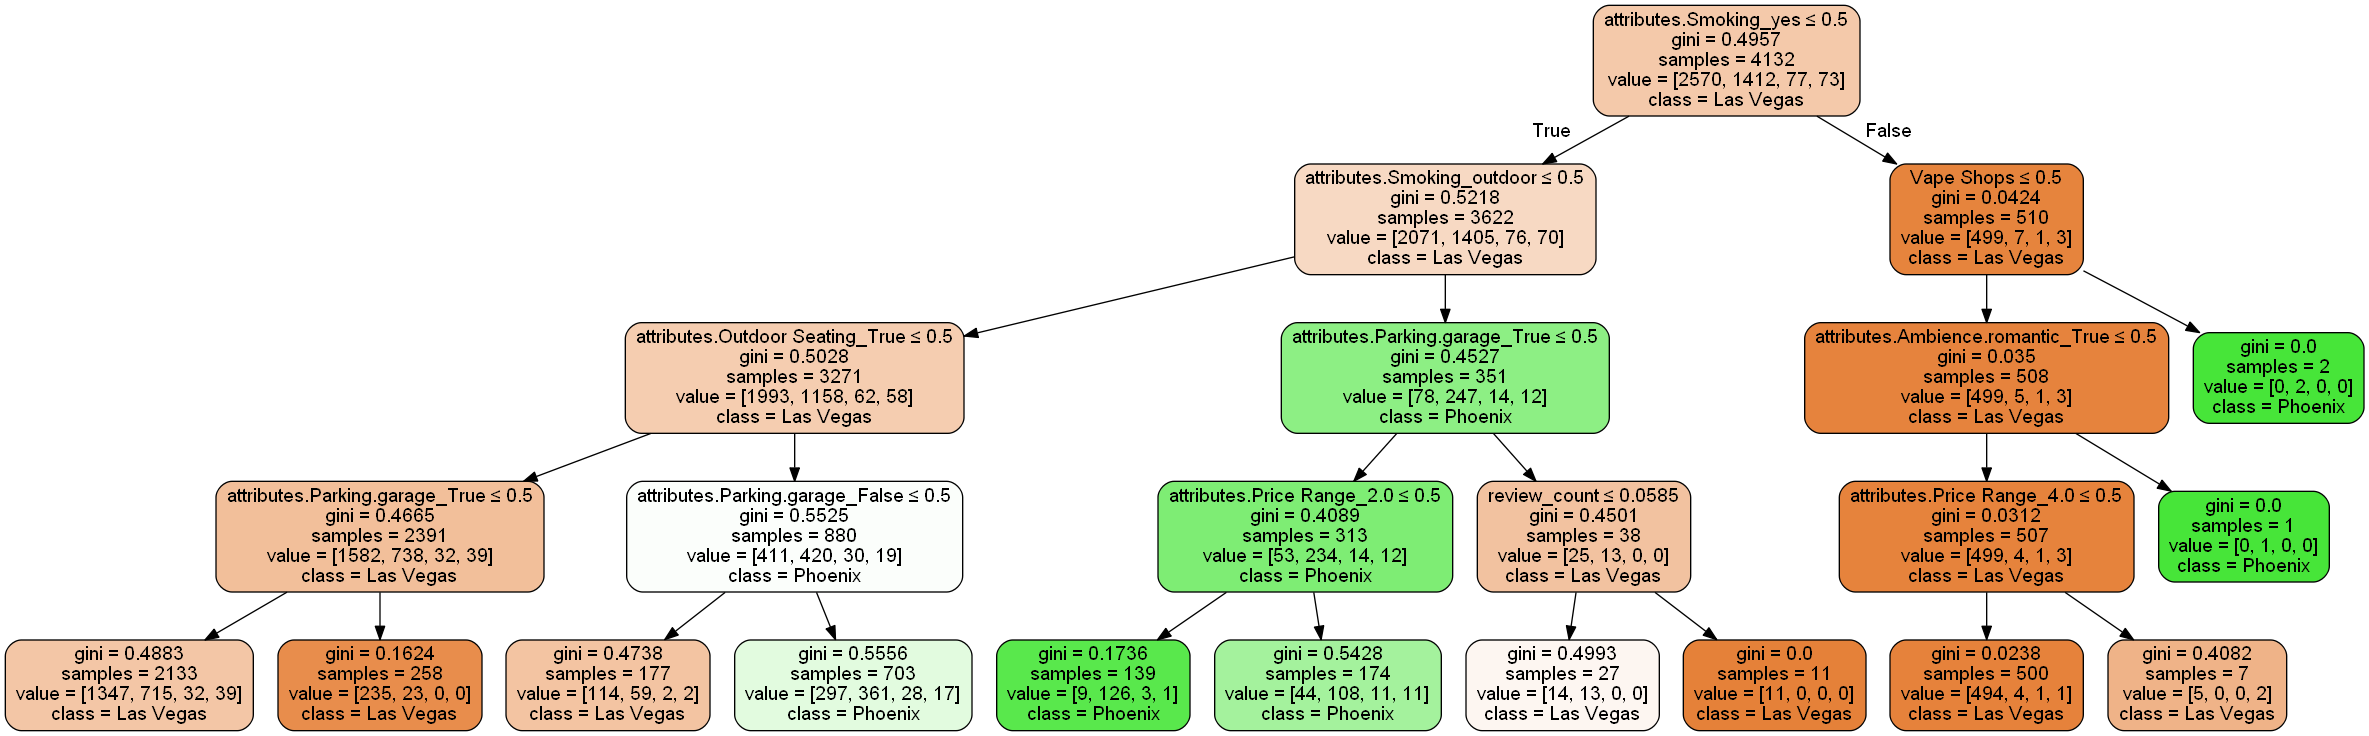

In [53]:
dot_data = StringIO()  

export_graphviz(dtc4, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X.columns,
               class_names = le.classes_)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
# Gridsearch:

In [42]:
dtc_params = {
    'max_depth':[None,1,2,3,4],
    'max_features':[None,'log2','sqrt',2,3,4,5],
    'min_samples_split':[2,3,4,5,10,15,20,25,30,40,50]
}

from sklearn.grid_search import GridSearchCV

dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=5, verbose=1)

C:\Program Files\Anaconda2\envs\Boost\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [43]:
dtc_gs.fit(X, y)

Fitting 5 folds for each of 385 candidates, totalling 1925 fits


[Parallel(n_jobs=1)]: Done 1925 out of 1925 | elapsed:  1.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50], 'max_features': [None, 'log2', 'sqrt', 2, 3, 4, 5], 'max_depth': [None, 1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [55]:
dtc_best = dtc_gs.best_estimator_

fi = pd.DataFrame({
        'feature':X.columns,
        'importance':dtc_best.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)
fi.head(10)

,feature,importance
137,attributes.Smoking_yes,0.398024
136,attributes.Smoking_outdoor,0.251681
122,attributes.Parking.garage_True,0.133303
120,attributes.Outdoor Seating_True,0.124978
121,attributes.Parking.garage_False,0.033970
132,attributes.Price Range_2.0,0.027422
17,Vape Shops,0.011279
0,review_count,0.010547
39,attributes.Ambience.romantic_True,0.005673
134,attributes.Price Range_4.0,0.003124


In [56]:
# Create Review Groupby object: Groups all the business IDs up so I can sum up all their scores
grouped = reviews.groupby('business_id')

# Sum up scores by business, and add the business id back in as a key if we want to join it to the master business df
business_review_summary = grouped.aggregate(np.sum)
business_review_summary['business_id'] = business_review_summary.index




In [57]:
business_review_summary.head()

,votes.cool,votes.funny,stars,votes.useful,10 minutes,15 minutes,20 minutes,30 minutes,bar food,beer selection,...,staff friendly,super friendly,sweet potato,tasted like,time vegas,try place,ve seen,ve tried,wait staff,business_id
business_id,,,,,,,,,,,,,,,,,,,,,
--jFTZmywe7StuZ2hEjxyA,11,7,17,13,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,--jFTZmywe7StuZ2hEjxyA
-0HGqwlfw3I8nkJyMHxAsQ,0,3,27,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,-0HGqwlfw3I8nkJyMHxAsQ
-0VK5Z1BfUHUYq4PoBYNLw,2,2,15,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0VK5Z1BfUHUYq4PoBYNLw
-0bUDim5OGuv8R0Qqq6J4A,1,2,15,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0bUDim5OGuv8R0Qqq6J4A
-1bOb2izeJBZjHC7NWxiPA,57,39,428,80,0,1,0,2,0,0,...,4,3,0,2,0,0,2,0,1,-1bOb2izeJBZjHC7NWxiPA


In [58]:
# business and reviews tables merged:
br = pd.merge(bca, business_review_summary, how = 'inner', on = 'business_id')

In [60]:
bc = bca[['business_id', 'city', 'review_count', 'stars']]

In [61]:
br2 = pd.merge(bc, business_review_summary, how = 'inner', on = 'business_id')

In [62]:
y2 = br2['city']

In [69]:
X2 = br2.iloc[:, 2:]

In [64]:
numerical_cols = X2.columns

In [65]:
X2.head()

,review_count,stars_x,votes.cool,votes.funny,stars_y,votes.useful,10 minutes,15 minutes,20 minutes,30 minutes,...,service great,staff friendly,super friendly,sweet potato,tasted like,time vegas,try place,ve seen,ve tried,wait staff
0,25,2.5,10,36,60,37,0,2,0,0,...,1,0,0,0,1,0,0,0,0,0
1,19,3.0,20,14,44,32,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,238,3.5,94,62,860,172,5,2,4,0,...,10,4,1,38,5,0,0,1,1,5
3,10,4.0,13,17,36,11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,205,3.5,103,94,631,185,3,4,2,2,...,9,1,0,8,2,0,0,2,1,3


In [ ]:
for k,v in enumerate(X2.columns):
    print(k,v)

In [83]:
X2 = X2.drop('las vegas', axis = 1)

In [86]:
X2 = X2.drop('time vegas', axis = 1)

In [ ]:
X2[numerical_cols] = normalize(X2[numerical_cols], axis = 0)
X2[numerical_cols] = X2[numerical_cols].apply(lambda x: MinMaxScaler(feature_range=(-1,1)).fit_transform(x));

In [89]:
dtc3a = DecisionTreeClassifier(max_depth=3)
dtc3a.fit(X2, y2)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

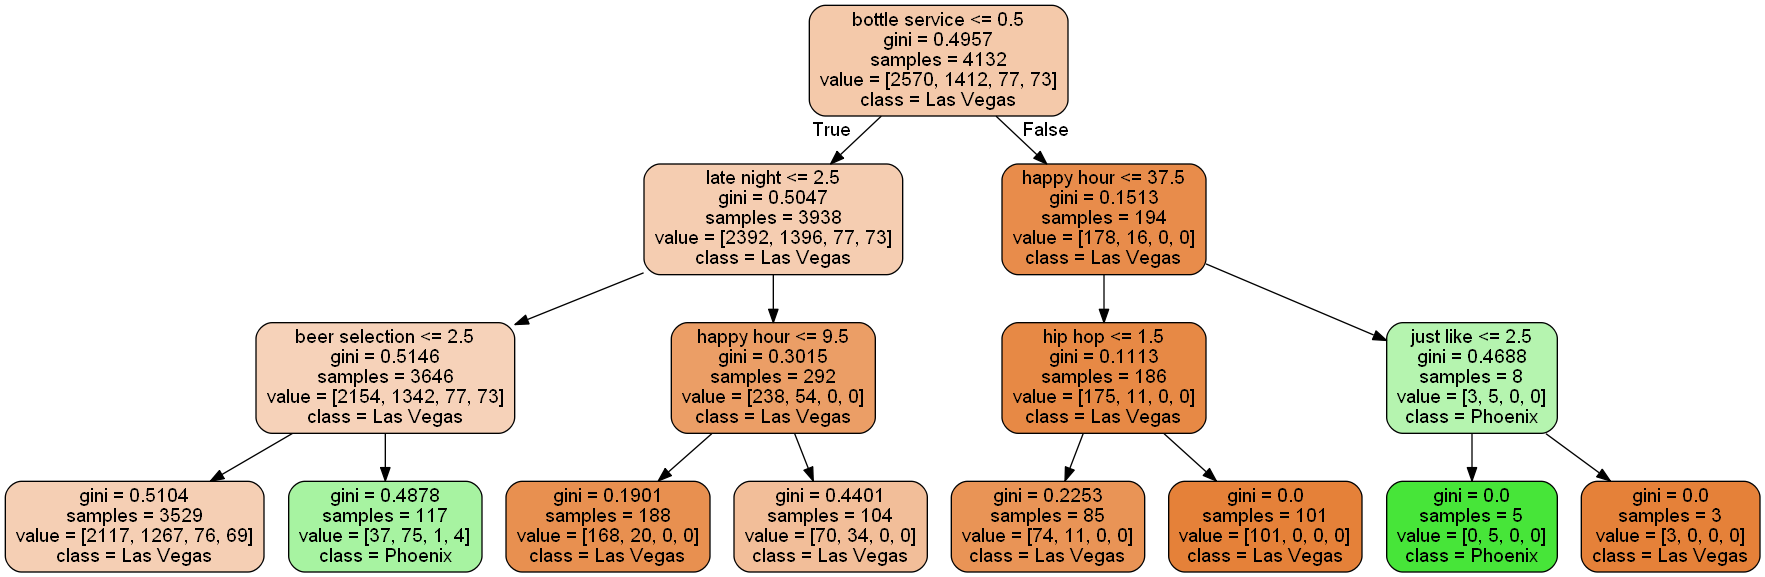

In [90]:
dot_data = StringIO()  

export_graphviz(dtc3a, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=False,
                feature_names=X2.columns,
                class_names = le.classes_)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [95]:
feature_importances = pd.DataFrame(dtc3a.feature_importances_,
                                   index = X2.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head(10)

,importance
bottle service,0.353526
late night,0.256184
beer selection,0.203195
happy hour,0.127838
just like,0.041958
hip hop,0.017298
looks like,0.000000
place good,0.000000
onion rings,0.000000
new york,0.000000


In [ ]:
# Depth of 5:

In [92]:
dtc5 = DecisionTreeClassifier(max_depth=5)
dtc5.fit(X2, y2)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

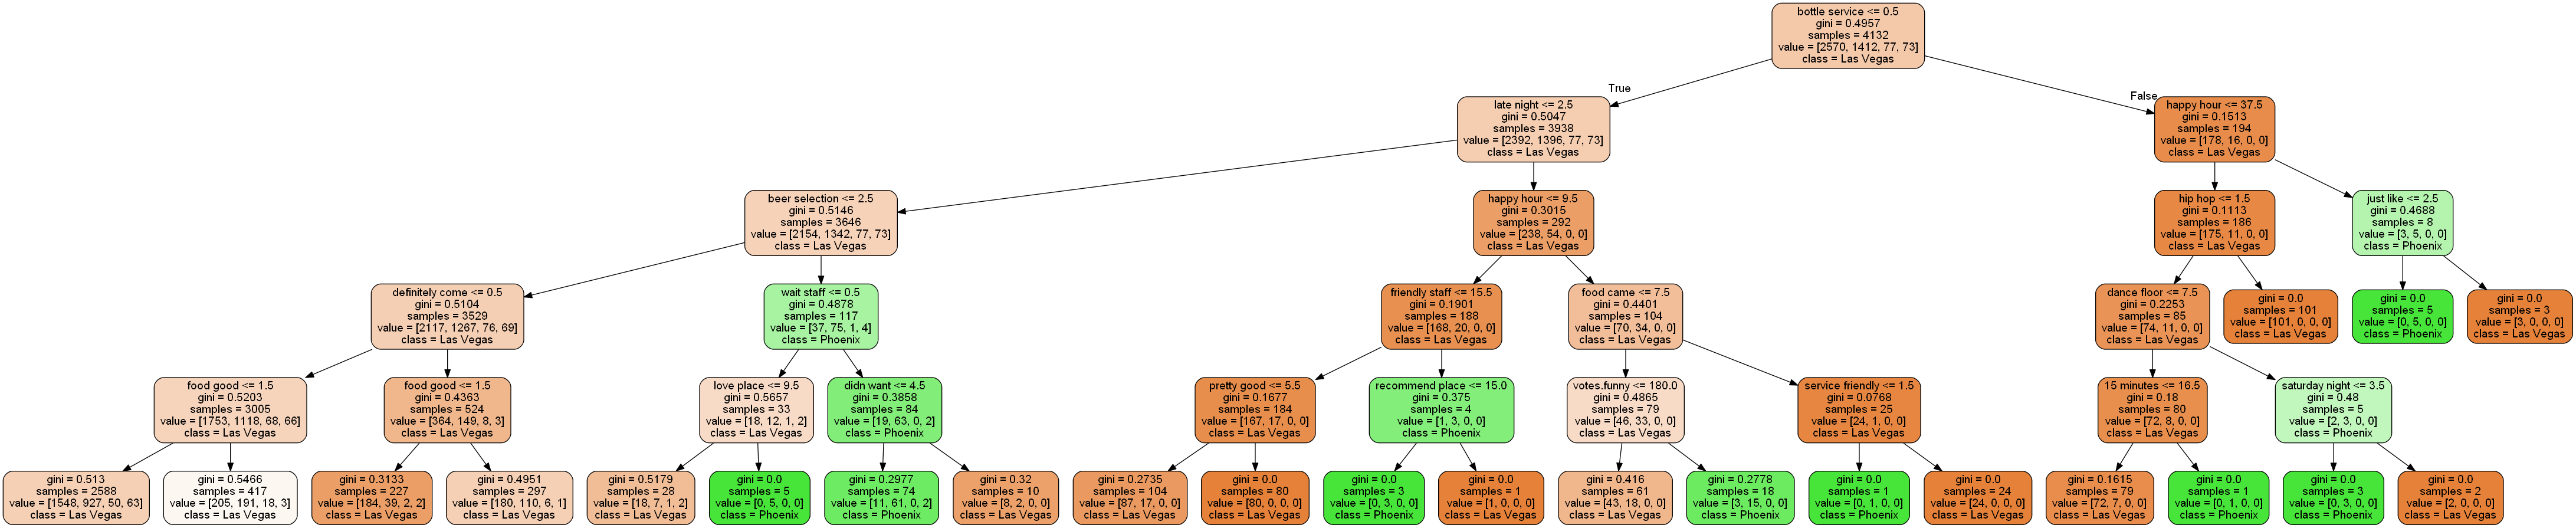

In [93]:
dot_data = StringIO()  

export_graphviz(dtc5, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=False,
                feature_names=X2.columns,
                class_names = le.classes_)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
numerical_cols2 = ['review_count', 'star']

In [ ]:
#######################################################################################################################

In [ ]:
####################################################    2    ###########################################################

In [105]:
servicec = ['business_id', 'city', 'review_count',  'stars',   'Airports', 'Comedy Clubs', 'Courthouses', 'Dance Clubs', 
       'Museums', 'Tattoo', 'Vape Shops', 'Yoga']

foodc = ['business_id', 'city', 'review_count',  'stars',
       'Breakfast & Brunch', 'Bubble Tea', 'Burgers',
       'Bars', 'Bakeries', 'Breweries', 'Cafes', 'Candy Stores',
       'Fast Food']

In [106]:
# Create flat df:
food = business_copy[foodc]

# Create flat df:
service = business_copy[servicec]

In [100]:
# Create Service df:
service_bus = service[['business_id', 'review_count', 'stars']]

service_bus = service_bus.drop_duplicates()

service_reviews = pd.merge(business_review_summary, service_bus, how = 'inner', on = 'business_id')


In [110]:
# service_reviews = service_reviews.drop('business_id', axis = 1)

In [107]:
# Create Food df:
food_bus = food[['business_id', 'review_count', 'stars']]

food_bus = food_bus.drop_duplicates()

food_reviews = pd.merge(business_review_summary, food_bus, how = 'inner', on = 'business_id')

In [108]:
# food_reviews = food_reviews.drop('business_id', axis = 1)

In [190]:
#food_reviews.head().T

In [111]:
# Create 'food' based 'cool votes' data
yf = food_reviews['votes.cool']
xf = food_reviews.drop('votes.cool', axis = 1)

In [112]:
# Create 'food' based 'useful votes' data
yfu = food_reviews['votes.useful']
xfu = food_reviews.drop('votes.useful', axis = 1)

In [ ]:
# Same but for service:

In [113]:
ys = service_reviews['votes.cool']
xs = service_reviews.drop('votes.cool', axis = 1)

In [114]:
ysu = service_reviews['votes.useful']
xsu = service_reviews.drop('votes.useful', axis = 1)

In [117]:
yf.shape, xf.shape, ys.shape, xs.shape

((4132,), (4132, 105), (4132,), (4132, 105))

In [118]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

In [120]:
regressor = DecisionTreeRegressor(random_state=0)
np.mean(cross_val_score(regressor, xf, yf, cv=10))

0.82536195762436848

In [121]:
regressor = DecisionTreeRegressor(random_state=0)
np.mean(cross_val_score(regressor, xs, ys, cv=10))

0.82536195762436848

In [225]:
regressor.fit(xf,yf)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best')

In [199]:
dt = DecisionTreeClassifier(class_weight='balanced')
s = cross_val_score(dt, xf, yf, cv=cv, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree", s.mean().round(3), s.std().round(3)))

Decision Tree Score:	0.136 ± 0.006


In [200]:
dt = DecisionTreeClassifier(class_weight='balanced')
s = cross_val_score(dt, xs, ys, cv=cv, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree", s.mean().round(3), s.std().round(3)))

Decision Tree Score:	0.133 ± 0.009


In [220]:
dt = DecisionTreeClassifier(class_weight='balanced')
s = cross_val_score(dt, xfu, yfu, cv=cv, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree", s.mean().round(3), s.std().round(3)))

Decision Tree Score:	0.079 ± 0.004


In [124]:
dt = DecisionTreeClassifier(class_weight='balanced')
s = cross_val_score(dt, xsu, ysu, cv=cv, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree", s.mean().round(3), s.std().round(3)))

Decision Tree Score:	0.079 ± 0.006


In [ ]:
####################################################    3    ###########################################################

In [137]:
# Seperate Elite Users by Year:

elite = users.elite.apply(eval)
users_copy = users.copy()
users_copy['elite'] = elite

elite_years_int = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,2016, 2017]

for year in elite_years_int:
    users_copy[year] = users_copy['elite'].apply(lambda x: year in x)
    

In [138]:
names = ['user_id', 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017] 

In [139]:
elites = users_copy[names]

In [140]:
elites.head()

,user_id,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,rpOyqD_893cqmDAtJLbdog,True,True,True,True,True,True,True,True,False,False
1,4U9kSBLuBDU391x6bxU-YA,True,True,True,True,True,True,True,True,False,False
2,SIBCL7HBkrP4llolm4SC2A,False,False,False,False,False,False,False,False,False,False
3,UTS9XcT14H2ZscRIf0MYHQ,False,False,False,False,False,False,False,False,False,False
4,ZWOj6LmzwGvMDh-A85EOtA,True,False,True,True,True,False,False,False,False,False


In [141]:
# Move years from wide to long:
melted = pd.melt(elites, id_vars=["user_id"], var_name="year", value_name="was_elite")

In [142]:
melted.head()

,user_id,year,was_elite
0,rpOyqD_893cqmDAtJLbdog,2008,True
1,4U9kSBLuBDU391x6bxU-YA,2008,True
2,SIBCL7HBkrP4llolm4SC2A,2008,False
3,UTS9XcT14H2ZscRIf0MYHQ,2008,False
4,ZWOj6LmzwGvMDh-A85EOtA,2008,True


In [ ]:
# Extract year from reviews:

In [143]:
reviews['date'] = pd.to_datetime(reviews['date'])

In [144]:
reviews['year'] = reviews['date'].dt.year

In [145]:
grouped = reviews.groupby(['user_id', 'year'])

In [146]:
user_stats = grouped.aggregate(np.sum)
cols = ['user_id', 'year', 'votes.cool', 'votes.funny','stars', 'votes.useful']
user_stats = user_stats.reset_index()
user_stats = user_stats[cols]
users_elite_year = pd.merge(melted, user_stats, how = "inner", on = ["user_id", "year"])

In [147]:
users_elite_year.head()

,user_id,year,was_elite,votes.cool,votes.funny,stars,votes.useful
0,4U9kSBLuBDU391x6bxU-YA,2008,True,2,2,3,3
1,UTS9XcT14H2ZscRIf0MYHQ,2008,False,1,0,5,2
2,ZWOj6LmzwGvMDh-A85EOtA,2008,True,9,7,15,11
3,AzoZZ1hRToPsnUPXeRXelg,2008,False,0,0,3,1
4,gdf9ftAOMms8JToU52uX2A,2008,False,0,0,31,1


In [148]:
users_elite_year = users_elite_year.drop('user_id', axis = 1)

In [149]:
users_elite_year = users_elite_year.drop('year', axis = 1)

In [150]:
le = LabelEncoder()
ye = le.fit_transform(users_elite_year['was_elite'])
Xe = users_elite_year.drop('was_elite', axis=1)

In [151]:
Xe.shape, ye.shape

((178849, 4), (178849,))

In [152]:
Xe.head()

,votes.cool,votes.funny,stars,votes.useful
0,2,2,3,3
1,1,0,5,2
2,9,7,15,11
3,0,0,3,1
4,0,0,31,1


In [153]:
def score(model, name):
    s = cross_val_score(model, Xe, ye, cv=cv, n_jobs=-1)
    print("{} Score:\t{:0.3} ± {:0.3}".format(name, s.mean().round(3), s.std().round(3)))

In [154]:
cv = StratifiedKFold(ye, n_folds=3, shuffle=True, random_state=41)

bdt = BaggingClassifier(DecisionTreeClassifier())
rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
et = ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)

score(dt, "Decision Tree")
score(bdt, "Bagging DT")
score(rf, "Random Forest")
score(et, "Extra Trees")

Decision Tree Score:	0.777 ± 0.01
Bagging DT Score:	0.892 ± 0.001
Random Forest Score:	0.794 ± 0.003
Extra Trees Score:	0.779 ± 0.01


In [155]:
dtc4 = DecisionTreeClassifier(max_depth=4)
dtc4.fit(Xe, ye)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

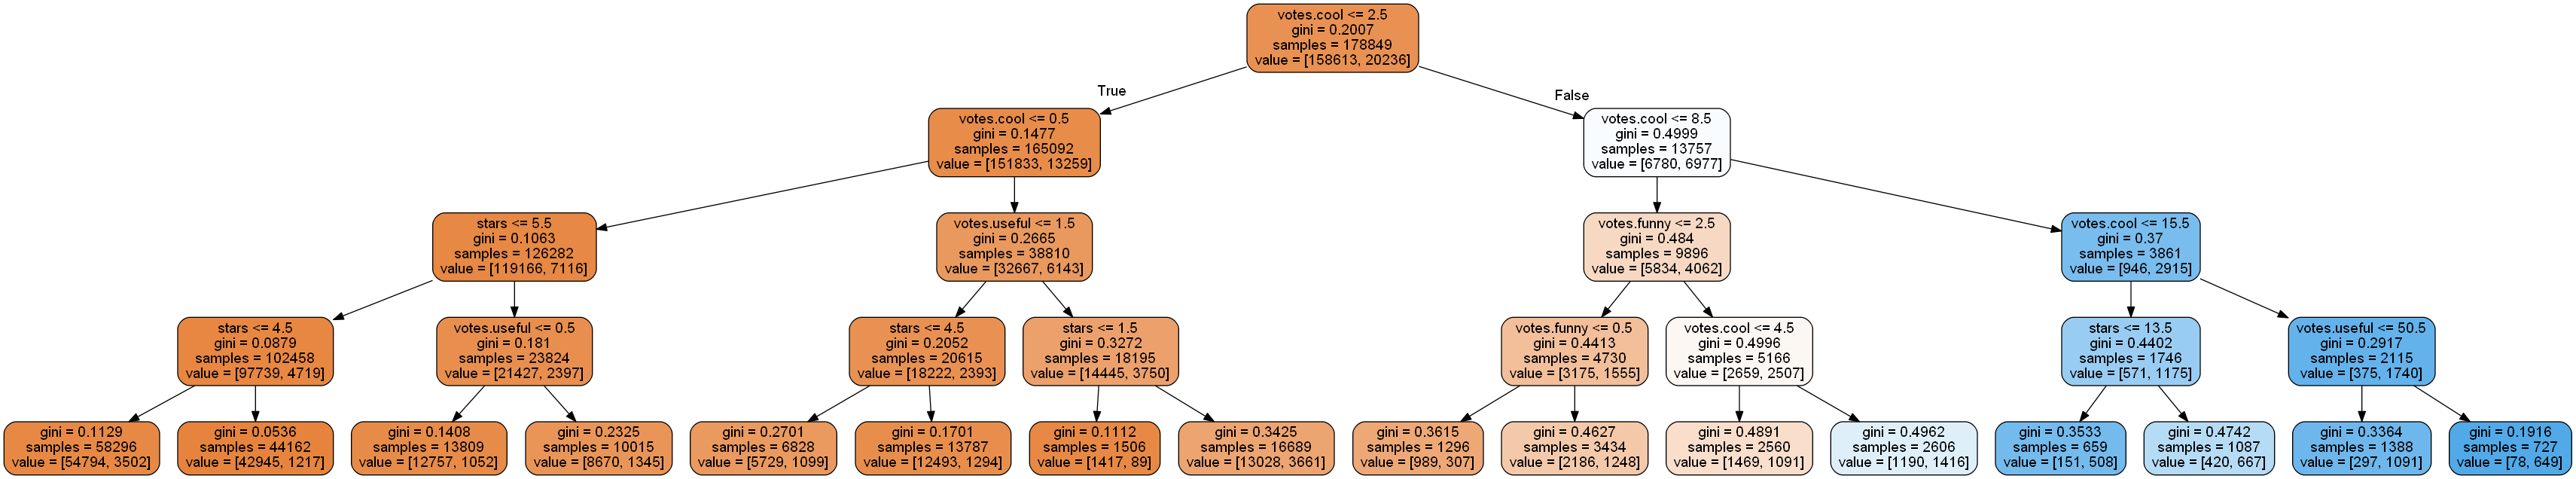

In [156]:
dot_data = StringIO()  

export_graphviz(dtc4, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=False,
                feature_names=Xe.columns)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [157]:
feature_importances = pd.DataFrame(dtc4.feature_importances_,
                                   index = Xe.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head(10)

,importance
votes.cool,0.900847
stars,0.045262
votes.useful,0.031130
votes.funny,0.022761
